# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



In [ ]:
# данные взяты отсюда https://www.kaggle.com/competitions/journey-springfield/data

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# установка подходящей версии torch
!pip install wheel==0.34.1
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp39-cp39-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.3 requires pillow!=7.1.0,!=7.1.1,!=8.3.0,>=6.1.0, but you have pillow 5.3.0 which is incompatible.
matplotlib 3.7.1 requires pillow>=6.2.0, but you have pillow 5.3.0 which is incompatible.
imageio 2.25.1 requires pillow>=8.3.2, but you have pillow 5.3.0 which is incompatible.
fastai 2.7.12 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
dopamine-rl 4.0.6 requires Pillow>=7.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.4.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
8.4.0

<ipython-input-40-cda5a773133b>:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in Pillow 9 (2022-01-02). Use __version__ instead.
  print(PIL.PILLOW_VERSION)


In [ ]:
# uncomment if you have problem with pillow
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions):
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 21 19:27:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
import pickle
import numpy as np
import time
import copy
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.9/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d data

replace data/characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/testset/testset/img0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [ ]:
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
print(len(train_val_files), 'train files')
print(len(test_files), 'test files')

20933 train files
991 test files


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

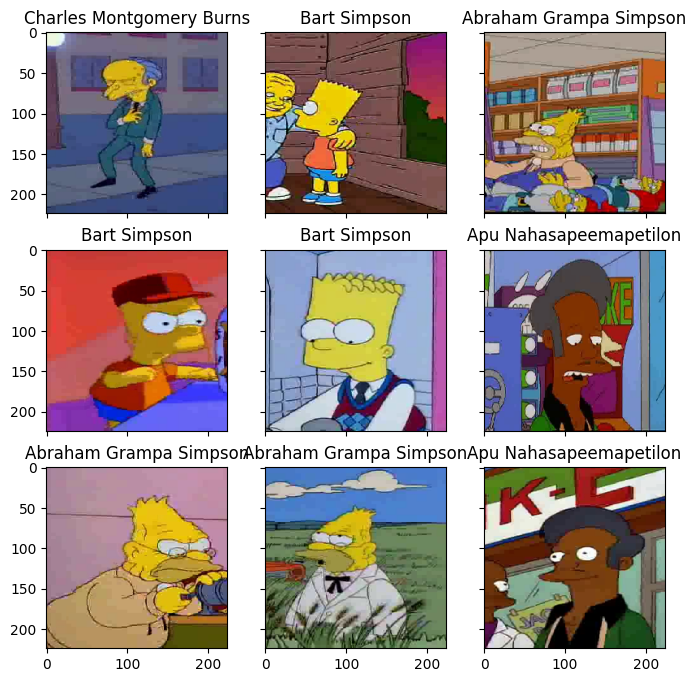

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

# Построение Efficient Net с fine-tuning

Функции для обучения

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        #сброс градиента
        optimizer.zero_grad()

        #предсказание, вычисление лосса
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        #обновление весов
        optimizer.step()

        #предсказание (класс)
        preds = torch.argmax(outputs, 1)


        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, criterion, epochs, batch_size, optimizer, scheduler):

    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("Train loss: ", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            print("Val loss: ", val_loss)

            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()

            #отображение статуса обучения
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            #if val_loss < best_loss:
                #best_acc = val_loss
                #best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    #model.load_state_dict(best_model_wts)
    #return model, losses

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Данные для обучения

In [ ]:
number_classes = len(np.unique(train_val_labels))
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Модель

Fine-tuning - классификатор

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, number_classes)

# Использовать ли GPU
model = model.to(DEVICE)

# В качестве cost function используем кросс-энтропию
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [ ]:
model.fc

Linear(in_features=512, out_features=42, bias=True)

In [ ]:
history_resnet = train(train_dataset, val_dataset, model=model, criterion=criterion, scheduler=exp_lr_scheduler, epochs=3, batch_size=256, optimizer=optimizer)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:  2.7110977383948973


epoch:  33%|███▎      | 1/3 [00:54<01:48, 54.46s/it]

Val loss:  2.1637228699554045

Epoch 001 train_loss: 2.7111     val_loss 2.1637 train_acc 0.2949 val_acc 0.4981
Train loss:  1.8502671418580912


epoch:  67%|██████▋   | 2/3 [01:46<00:52, 52.75s/it]

Val loss:  1.6669502925180415

Epoch 002 train_loss: 1.8503     val_loss 1.6670 train_acc 0.5930 val_acc 0.6234
Train loss:  1.4784830047625768


epoch: 100%|██████████| 3/3 [02:39<00:00, 53.13s/it]

Val loss:  1.4304055532609228

Epoch 003 train_loss: 1.4785     val_loss 1.4304 train_acc 0.6656 val_acc 0.6603
Training complete in 2m 39s


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet)

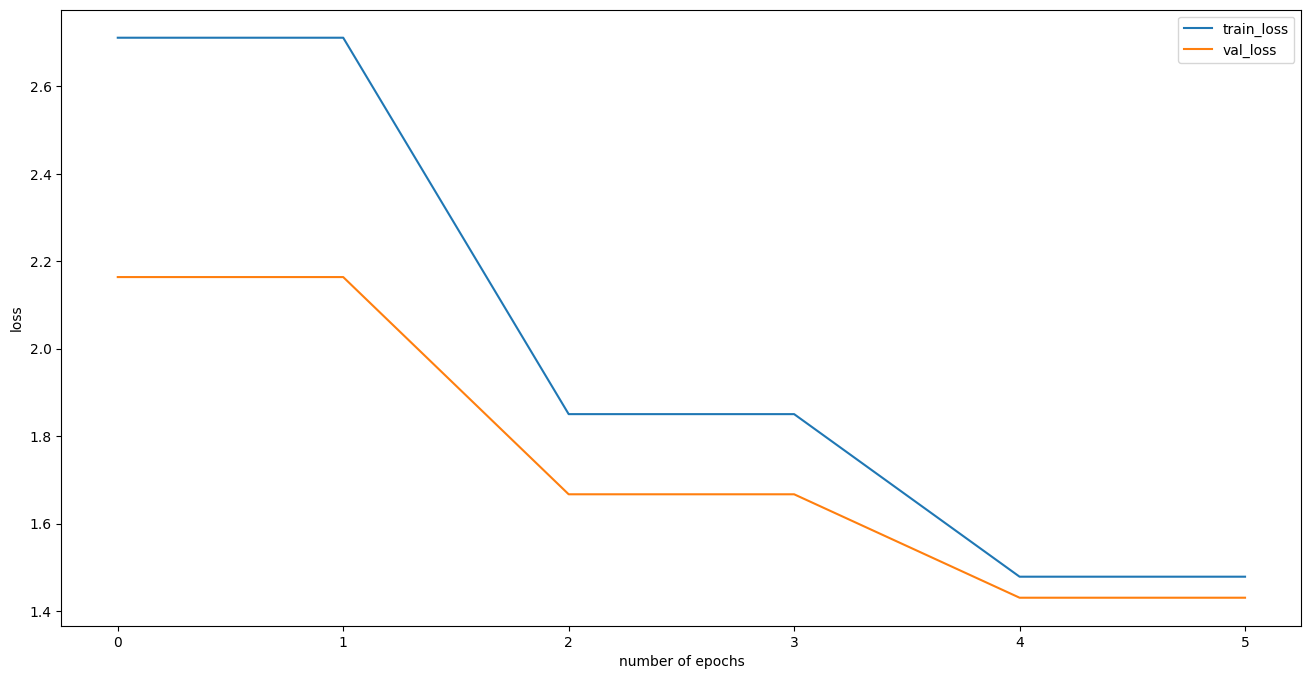

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

Обучение всех слоёв

In [ ]:
for param in model.parameters():
    param.requires_grad = True

history_resnet_all = train(train_dataset, val_dataset, model=model, criterion=criterion, scheduler=exp_lr_scheduler, epochs=25, batch_size=128, optimizer=optimizer)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Train loss:  3.2404866857782


epoch:   4%|▍         | 1/25 [01:07<27:10, 67.95s/it]

Val loss:  3.0447703865497315

Epoch 001 train_loss: 3.2405     val_loss 3.0448 train_acc 0.0980 val_acc 0.1104
Train loss:  2.841925514299434


epoch:   8%|▊         | 2/25 [02:16<26:12, 68.37s/it]

Val loss:  2.6125146102759507

Epoch 002 train_loss: 2.8419     val_loss 2.6125 train_acc 0.1796 val_acc 0.2436
Train loss:  2.202552103739619


epoch:  12%|█▏        | 3/25 [03:24<25:00, 68.19s/it]

Val loss:  1.8069614416595448

Epoch 003 train_loss: 2.2026     val_loss 1.8070 train_acc 0.3770 val_acc 0.4817
Train loss:  1.5008988407996287


epoch:  16%|█▌        | 4/25 [04:33<23:59, 68.55s/it]

Val loss:  1.205317547451598

Epoch 004 train_loss: 1.5009     val_loss 1.2053 train_acc 0.5797 val_acc 0.6685
Train loss:  1.0415740854550763


epoch:  20%|██        | 5/25 [05:41<22:46, 68.34s/it]

Val loss:  1.0433429252295081

Epoch 005 train_loss: 1.0416     val_loss 1.0433 train_acc 0.7124 val_acc 0.7098
Train loss:  0.8101078925204738


epoch:  24%|██▍       | 6/25 [06:53<22:03, 69.66s/it]

Val loss:  0.9422784131312124

Epoch 006 train_loss: 0.8101     val_loss 0.9423 train_acc 0.7743 val_acc 0.7394
Train loss:  0.6222163013906508


epoch:  28%|██▊       | 7/25 [08:02<20:45, 69.18s/it]

Val loss:  0.6742941362510714

Epoch 007 train_loss: 0.6222     val_loss 0.6743 train_acc 0.8262 val_acc 0.8216
Train loss:  0.4415254765000645


epoch:  32%|███▏      | 8/25 [09:11<19:35, 69.14s/it]

Val loss:  0.6423030143299766

Epoch 008 train_loss: 0.4415     val_loss 0.6423 train_acc 0.8741 val_acc 0.8328
Train loss:  0.3575362321529216


epoch:  36%|███▌      | 9/25 [10:19<18:21, 68.82s/it]

Val loss:  0.6253824721413985

Epoch 009 train_loss: 0.3575     val_loss 0.6254 train_acc 0.8968 val_acc 0.8399
Train loss:  0.294905222557982


epoch:  40%|████      | 10/25 [11:26<17:05, 68.35s/it]

Val loss:  0.6227155251953044

Epoch 010 train_loss: 0.2949     val_loss 0.6227 train_acc 0.9152 val_acc 0.8529
Train loss:  0.2390169958068547


epoch:  44%|████▍     | 11/25 [12:35<15:58, 68.45s/it]

Val loss:  0.7043966759604081

Epoch 011 train_loss: 0.2390     val_loss 0.7044 train_acc 0.9297 val_acc 0.8357
Train loss:  0.212069614970902


epoch:  48%|████▊     | 12/25 [13:42<14:44, 68.01s/it]

Val loss:  0.7298935443607049

Epoch 012 train_loss: 0.2121     val_loss 0.7299 train_acc 0.9360 val_acc 0.8393
Train loss:  0.1735225068073651


epoch:  52%|█████▏    | 13/25 [15:02<14:22, 71.84s/it]

Val loss:  0.618089476477157

Epoch 013 train_loss: 0.1735     val_loss 0.6181 train_acc 0.9480 val_acc 0.8619
Train loss:  0.14226956697882903


epoch:  56%|█████▌    | 14/25 [16:12<13:03, 71.20s/it]

Val loss:  0.7343697019169063

Epoch 014 train_loss: 0.1423     val_loss 0.7344 train_acc 0.9555 val_acc 0.8506
Train loss:  0.1552685416204564


epoch:  60%|██████    | 15/25 [17:20<11:41, 70.13s/it]

Val loss:  0.7727320308351863

Epoch 015 train_loss: 0.1553     val_loss 0.7727 train_acc 0.9543 val_acc 0.8494
Train loss:  0.12265477957137186


epoch:  64%|██████▍   | 16/25 [18:33<10:40, 71.15s/it]

Val loss:  0.8559622599689569

Epoch 016 train_loss: 0.1227     val_loss 0.8560 train_acc 0.9637 val_acc 0.8500
Train loss:  0.16580952585210496


epoch:  68%|██████▊   | 17/25 [19:44<09:28, 71.03s/it]

Val loss:  0.6331967181452458

Epoch 017 train_loss: 0.1658     val_loss 0.6332 train_acc 0.9489 val_acc 0.8718
Train loss:  0.08075500114460388


epoch:  72%|███████▏  | 18/25 [20:58<08:22, 71.84s/it]

Val loss:  0.7005903432967784

Epoch 018 train_loss: 0.0808     val_loss 0.7006 train_acc 0.9768 val_acc 0.8724
Train loss:  0.09329445210962783


epoch:  76%|███████▌  | 19/25 [22:11<07:13, 72.27s/it]

Val loss:  0.7729885684291415

Epoch 019 train_loss: 0.0933     val_loss 0.7730 train_acc 0.9738 val_acc 0.8678
Train loss:  0.06412796642391862


epoch:  80%|████████  | 20/25 [23:21<05:57, 71.55s/it]

Val loss:  0.7648899862226021

Epoch 020 train_loss: 0.0641     val_loss 0.7649 train_acc 0.9806 val_acc 0.8603
Train loss:  0.09021622940961536


epoch:  84%|████████▍ | 21/25 [24:29<04:42, 70.53s/it]

Val loss:  0.8192570737677309

Epoch 021 train_loss: 0.0902     val_loss 0.8193 train_acc 0.9736 val_acc 0.8634
Train loss:  0.07220404824126077


epoch:  88%|████████▊ | 22/25 [25:38<03:30, 70.19s/it]

Val loss:  0.8075830569283672

Epoch 022 train_loss: 0.0722     val_loss 0.8076 train_acc 0.9794 val_acc 0.8525
Train loss:  0.07412934266075874


epoch:  92%|█████████▏| 23/25 [26:48<02:19, 69.91s/it]

Val loss:  0.6940944795623097

Epoch 023 train_loss: 0.0741     val_loss 0.6941 train_acc 0.9799 val_acc 0.8768
Train loss:  0.054811141941383416


epoch:  96%|█████████▌| 24/25 [27:56<01:09, 69.49s/it]

Val loss:  0.7079793360108495

Epoch 024 train_loss: 0.0548     val_loss 0.7080 train_acc 0.9838 val_acc 0.8773
Train loss:  0.058444089022432366


epoch: 100%|██████████| 25/25 [29:04<00:00, 69.77s/it]

Val loss:  0.8477149934407906

Epoch 025 train_loss: 0.0584     val_loss 0.8477 train_acc 0.9831 val_acc 0.8559
Training complete in 29m 4s


In [ ]:
loss, acc, val_loss, val_acc = zip(*history_resnet_all)

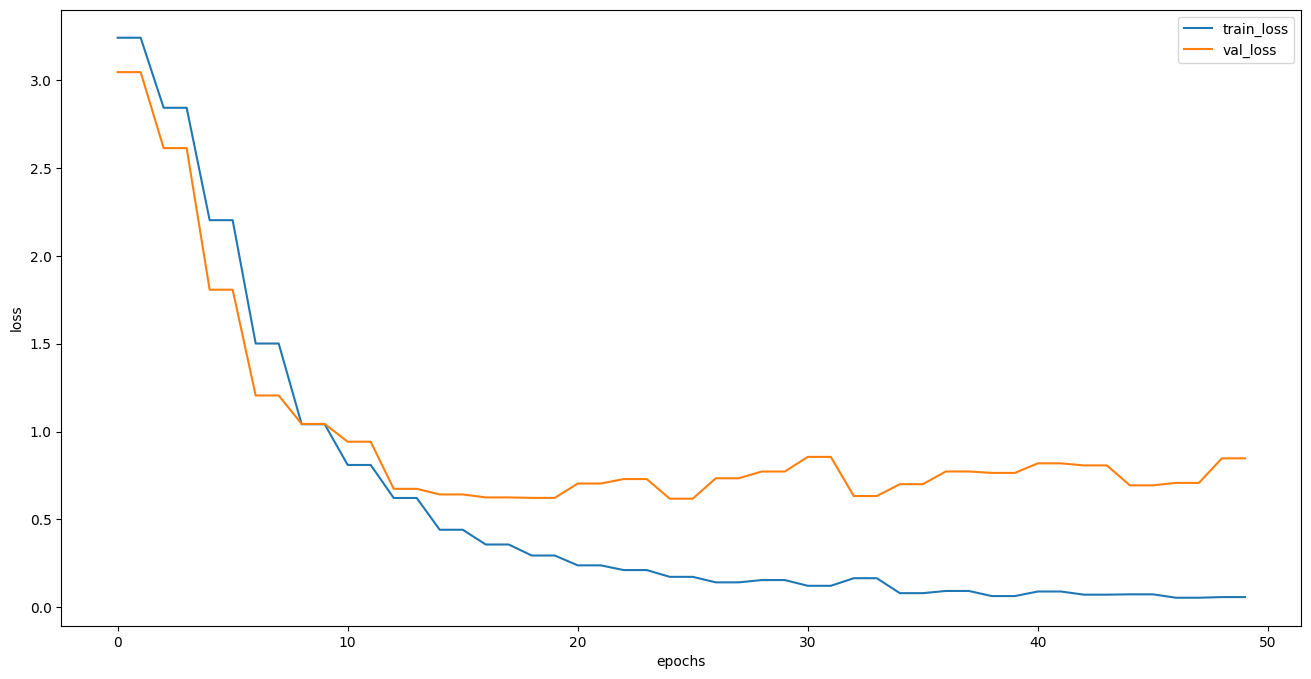

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
print(probs_ims)

[[9.16920873e-10 7.95850558e-15 4.80629618e-15 7.04651004e-09
  9.99999523e-01 1.98090442e-18 4.65409961e-10 3.60026310e-12
  7.84519070e-17 2.59092505e-14 4.10858974e-26 8.27936851e-12
  8.26779182e-18 1.40459673e-18 1.35656333e-14 1.10979170e-09
  5.92657027e-14 2.16159813e-13 1.31226807e-18 1.21103414e-22
  3.05522576e-07 2.93484637e-09 1.10919913e-13 2.45324106e-13
  4.22373191e-15 6.34426019e-12 2.09085911e-15 5.66251249e-14
  1.59688202e-12 3.58972400e-12 5.49987426e-18 1.43402087e-12
  2.15550876e-17 7.52920504e-10 1.17906076e-15 1.49646908e-07
  5.40233590e-16 3.73626260e-12 6.58910487e-15 1.42157647e-18
  1.27327552e-21 1.20298491e-16]
 [5.09292027e-03 8.75916041e-04 1.59709554e-04 3.41945648e-04
  1.22727146e-02 6.33368210e-04 2.35689129e-03 1.68105797e-03
  2.17953220e-06 1.07531603e-02 3.44582477e-05 7.65718669e-02
  9.97627397e-11 1.06181507e-03 4.81170673e-06 2.83535616e-03
  9.47308727e-05 9.59001500e-06 6.72560418e-05 2.29435273e-07
  1.38460593e-02 3.14713136e-04 2.715

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels

[4, 6, 6, 0, 0, 2, 2, 6, 6, 1, 0, 2, 0, 4, 5, 2, 0, 2, 5, 6]

In [ ]:
y_pred

array([ 4, 28,  6,  0,  0,  2,  2,  6,  6, 16,  0,  2,  0,  4,  2,  2,  0,
        2,  5,  6])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')


0.8661616161616161

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

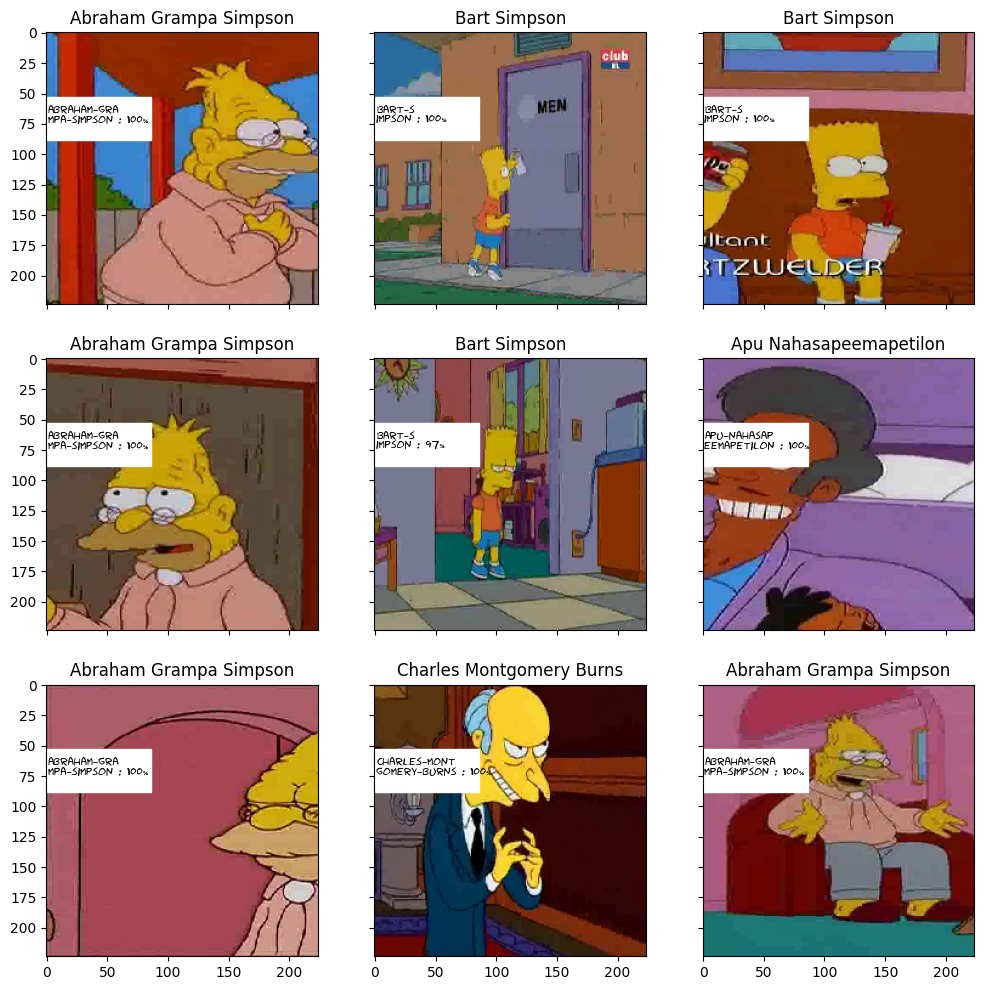

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

data  gdrive  label_encoder.pkl  sample_data


In [ ]:
import pandas as pd
s_submit = pd.read_csv("data/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
s_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/dlSchool/simple_cnn_baseline.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
